## 0. Load datasets

In [16]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

%matplotlib widget

In [17]:
# Load data
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
model_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Random_forest_division'

all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in divisions.columns if 'Time' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'standard' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'cell coords' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'duration' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'Manual' in f]
features2drop += [(f,a) for f,a in divisions.columns if '2um' in f]
features2drop += [(f,a) for f,a in divisions.columns if '10um' in f]
features2drop += [(f,a) for f,a in divisions.columns if '15um' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'Total' in f]
features2drop += ['Z','Z-cyto']
divisions = divisions.drop(columns=features2drop)
print(len(divisions))

# Load images
from skimage import io
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}

tracked_cyto_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif')) for name,dirname in dirnames.items()}
tracked_nuc_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_nuc.tif')) for name,dirname in dirnames.items()}
adjdict_by_region = {name: [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item() for t in range(15)] for name,dirname in dirnames.items()}

divisions['Relative Height to BM'].loc[13]

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_81702/1476871566.py:21: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  divisions = divisions.drop(columns=features2drop)


668


Metadata  Measurement
TrackID              
R1_324       0.971811
R1_346       1.002587
R1_441       0.875209
R1_449       0.951706
R1_565       0.937892
R1_656       1.012544
R1_916       0.996142
R2_294       1.019969
R2_388       0.984184
R2_529       1.056475
R2_680       0.832155
R2_817       0.917853
R2_951       1.048279

In [18]:
# Grouped Standard Scaler
class GroupedStandardScaler(BaseEstimator, TransformerMixin):
    """
    Standardize features by removing the mean and scaling to unit variance,
    computed separately for each group defined by a categorical variable.
    
    Parameters
    ----------
    group_col : str
        Name of the categorical column to group by for standardization
    
    with_mean : bool, default=True
        If True, center the data before scaling
    
    with_std : bool, default=True
        If True, scale the data to unit variance
    
    Attributes
    ----------
    group_means_ : dict
        Dictionary mapping group values to mean arrays
    
    group_stds_ : dict
        Dictionary mapping group values to standard deviation arrays
    
    feature_names_ : list
        List of feature column names (excluding group_col)
    
    groups_ : array
        Unique group values seen during fit
    """
    
    def __init__(self, group_col, with_mean=True, with_std=True):
        self.group_col = group_col
        self.with_mean = with_mean
        self.with_std = with_std
    
    def fit(self, X, y=None):
        """
        Compute the mean and std to be used for later scaling, per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data used to compute the per-group means and standard deviations
            used for later scaling along the features axis.
        
        y : None
            Ignored
        
        Returns
        -------
        self : object
            Fitted scaler
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Store feature names (excluding group column)
        self.feature_names_ = [col for col in X.columns if col != self.group_col]
        
        # Use groupby for vectorized computation
        grouped = X.groupby(self.group_col)[self.feature_names_]
        
        if self.with_mean:
            self.group_means_ = grouped.mean()
        else:
            self.group_means_ = pd.DataFrame(
                0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        if self.with_std:
            self.group_stds_ = grouped.std()
            # Replace zero std with 1 to avoid division by zero
            self.group_stds_ = self.group_stds_.replace(0, 1.0)
        else:
            self.group_stds_ = pd.DataFrame(
                1.0, 
                index=grouped.groups.keys(), 
                columns=self.feature_names_
            )
        
        return self
    
    def transform(self, X):
        """
        Perform standardization by centering and scaling per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to transform
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy to avoid modifying original
        X_transformed = X.copy()
        
        # Align means and stds with X using merge (much faster than map)
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized standardization
        X_transformed[self.feature_names_] = (
            X[self.feature_names_].values - means_aligned[self.feature_names_].values
        ) / stds_aligned[self.feature_names_].values
        
        # Check for unseen groups (NaN values after join)
        if means_aligned[self.feature_names_].isna().any().any():
            unseen_groups = X.loc[means_aligned[self.feature_names_].isna().any(axis=1), self.group_col].unique()
            import warnings
            warnings.warn(f"Found unseen groups during transform: {unseen_groups}. These samples will not be standardized.")
            # Keep original values for unseen groups (where NaN resulted)
            nan_mask = means_aligned[self.feature_names_].isna().any(axis=1)
            X_transformed.loc[nan_mask, self.feature_names_] = X.loc[nan_mask, self.feature_names_]
        
        return X_transformed.drop(columns=self.group_col)
    
    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            Input data
        
        y : None
            Ignored
        
        Returns
        -------
        X_transformed : pandas DataFrame of shape (n_samples, n_features)
            Transformed DataFrame
        """
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Scale back the data to the original representation per group.
        
        Parameters
        ----------
        X : pandas DataFrame of shape (n_samples, n_features)
            The data to inverse transform
        
        Returns
        -------
        X_original : pandas DataFrame of shape (n_samples, n_features)
            DataFrame in original scale
        """
        check_is_fitted(self, ['group_means_', 'group_stds_', 'feature_names_'])
        
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        
        if self.group_col not in X.columns:
            raise ValueError(f"group_col '{self.group_col}' not found in DataFrame")
        
        # Create a copy
        X_original = X.copy()
        
        # Align means and stds with X using merge
        means_aligned = X[[self.group_col]].join(
            self.group_means_, on=self.group_col, how='left'
        )
        stds_aligned = X[[self.group_col]].join(
            self.group_stds_, on=self.group_col, how='left'
        )
        
        # Vectorized inverse transformation
        X_original[self.feature_names_] = (
            X[self.feature_names_].values * stds_aligned[self.feature_names_].values
        ) + means_aligned[self.feature_names_].values
        
        return X_original
        


In [19]:
# Helper functions
def get_balanced_df_by_category(df,category,subsample=None,replacement=True):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]

    num_to_sample = min(subsample if subsample is not None else num_per_category.min(), num_per_category.min())
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member.sample(num_to_sample,replace=replacement))
        else:
            output.append(member.sample(num_to_sample,replace=replacement))
    output = pd.concat(output,ignore_index=True)
    
    return output

def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    groupby_name = 'Region',
                    Niter:int=100,
                    model_params = {},
                    measurement_level_name:str='Measurement'):
    training_set = []
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        # GroupedStandardScaler('Region')
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      classifier(random_state=i,**model_params) )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        # X['Region'] = df_['Region']
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,random_state=i+1)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))

        training_set.append((X_train,y_train,X_test,y_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models,training_set]
    

## 1. Predict from mother division frame

In [20]:
feature2predict = 'At least one daughter differentiated'
divisions = divisions.dropna(subset=[(feature2predict,'Meta')])

divisions.droplevel(axis=1,level=1).groupby(feature2predict).count()['X']

At least one daughter differentiated
False     72
True     231
Name: X, dtype: int64

In [21]:
# Check scaling functions
scaler = GroupedStandardScaler('Region')
X = divisions.xs('Measurement',level=1,axis=1)
X['Region'] = divisions['Region']
scaled_by_region = scaler.fit_transform(X)

standard_scaler = preprocessing.StandardScaler()
scaled_standard = standard_scaler.fit_transform(X.drop(columns='Region'))

plt.scatter(scaled_by_region.values.flatten(),scaled_standard.flatten() , alpha=0.1)
plt.xlabel('Scaled by region'); plt.ylabel('Scaled across regions')

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_81702/3411344348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Region'] = divisions['Region']
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_81702/4132026614.py:132: UserWarning: Found unseen groups during transform: ['R1' 'R2']. These samples will not be standardized.
  warnings.warn(f"Found unseen groups during transform: {unseen_groups}. These samples will not be standardized.")
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: 

Text(90.78125, 0.5, 'Scaled across regions')

In [22]:
# Run classifier
# axis0: observation axis1: prediction
from sklearn import ensemble

predictions,models,training_sets = predict_feature(divisions,
                                     ensemble.RandomForestClassifier,
                                     feature2predict,Niter=100)


  0%|                                                                                               | 0/100 [00:00<?, ?it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
  1%|▊                                                                                      | 1/100 [00:00<00:12,  8.14it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + n

0.7728749673771885


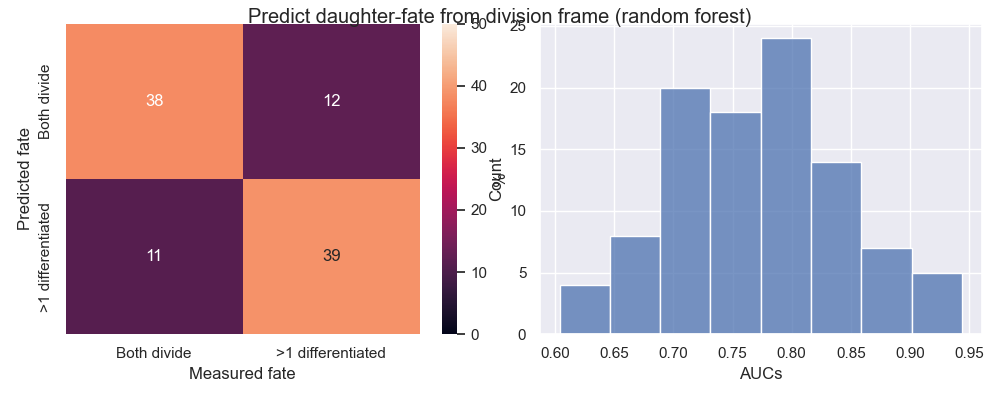

In [23]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.close('all')
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.set(font_scale=1)  # crazy big
# plt.title('Predict daughter-fate from division frame (SVM)')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.gca().set_xticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.gca().set_yticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')
plt.tight_layout()
# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.subplot(1,2,2)
sb.histplot(AUCs)
plt.xlabel('AUCs')

plt.suptitle('Predict daughter-fate from division frame (random forest)')
fig.savefig(path.join(model_dir,'RF_accuracy.svg'))
print(AUCs.mean())

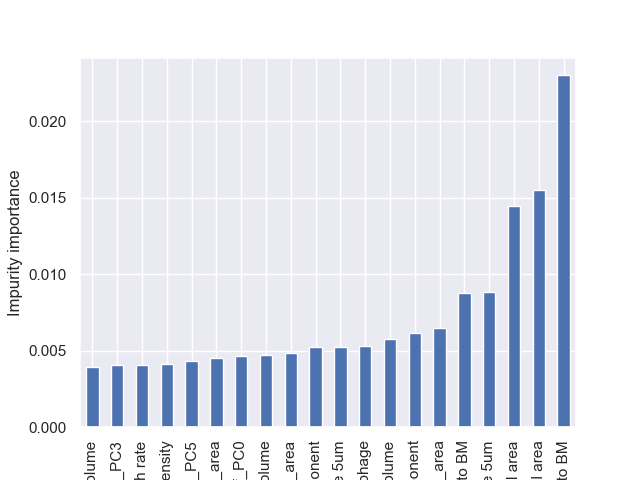

In [24]:
feat_names = divisions.xs('Measurement',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

fig = plt.figure()
importances.dropna(how='all').mean(axis=0).sort_values().tail(20).plot.bar()
plt.ylabel('Impurity importance')
plt.show()
plt.tight_layout()
fig.savefig(path.join(model_dir,'RF_impurity_importances.svg'))

importances.mean().sort_values().to_csv(path.join(model_dir,'importances.csv'))

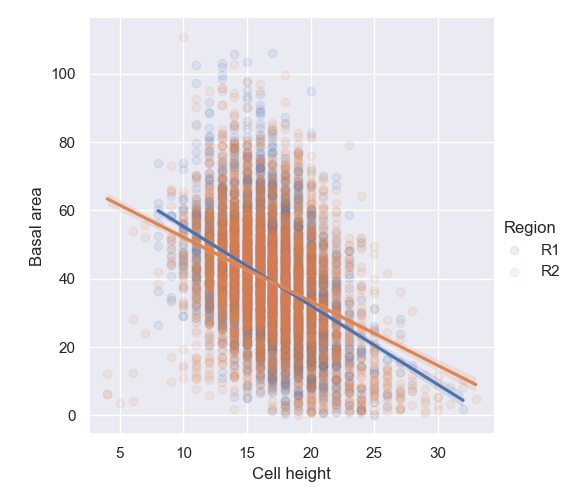

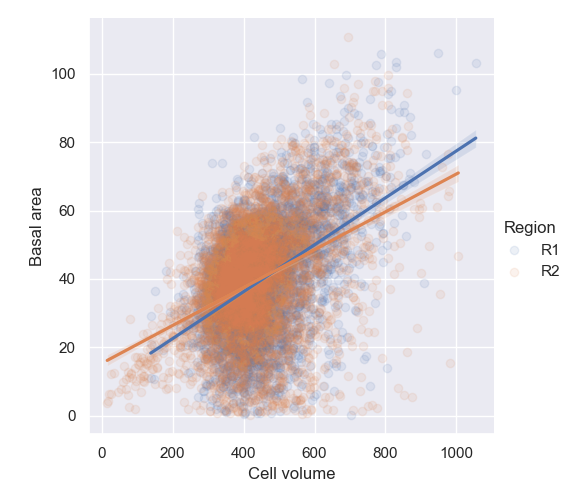

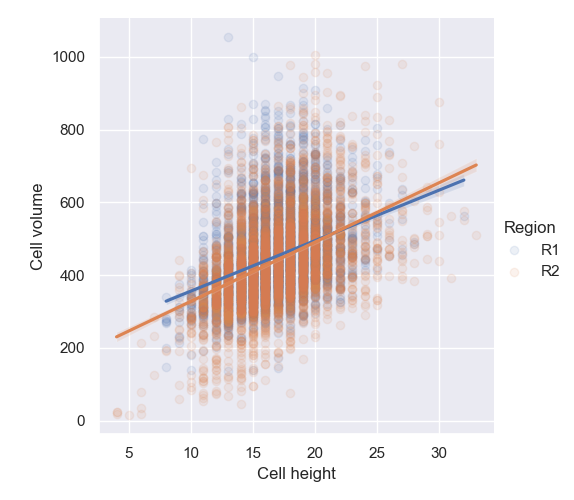

In [37]:
sb.lmplot(all_df,x='Cell height',y='Basal area',hue='Region',scatter_kws={'alpha':0.1})
sb.lmplot(all_df,x='Cell volume',y='Basal area',hue='Region',scatter_kws={'alpha':0.1})
sb.lmplot(all_df,x='Cell height',y='Cell volume',hue='Region',scatter_kws={'alpha':0.1})

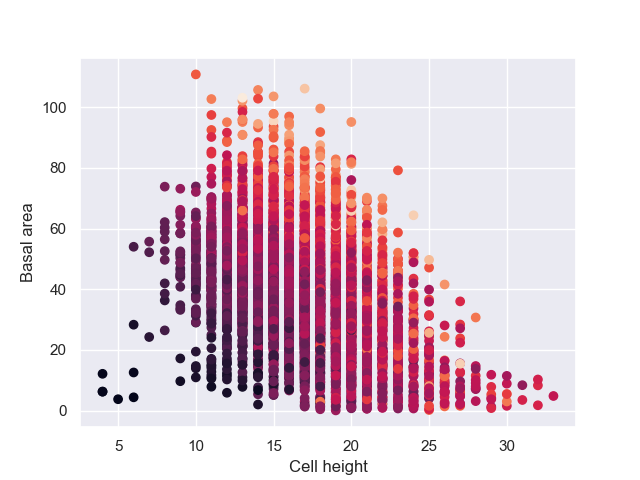

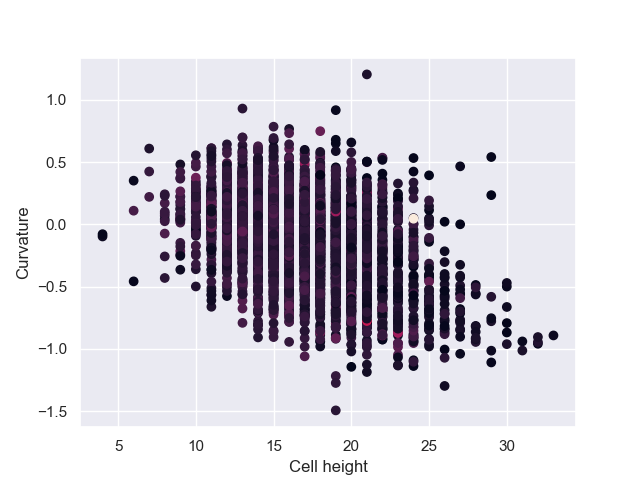

In [406]:
ax = plt.figure()
_df = all_df.droplevel(axis=1,level=1)
plt.scatter(_df['Cell height'],_df['Basal area'],c=_df['Cell volume'])
plt.xlabel('Cell height'); plt.ylabel('Basal area');
# ax.set_zlabel('Cell height')

ax = plt.figure()
_df = all_df.droplevel(axis=1,level=1)
plt.scatter(_df['Cell height'],_df['Mean curvature 5um'],c=_df['Relative Basal area'])
plt.xlabel('Cell height'); plt.ylabel('Curvature');
# ax.set_zlabel('Cell height')


# Cross-region predictions

In [276]:
X_train.shape

(64, 1385)

In [297]:
region2train = 'R2'
region2predict = 'R1'

Niter = 100

confusion = np.zeros((Niter,2,2))
for i in range(Niter):

    X_train = divisions[divisions['Region'] == region2train].xs('Measurement',level=1,axis=1)
    y_train = divisions[divisions['Region'] == region2train][feature2predict,'Meta'].astype(bool)
    X_train[feature2predict] = y_train
    X_train = get_balanced_df_by_category(X_train,feature2predict)
    y_train = X_train[feature2predict]
    X_train = X_train.drop(columns=feature2predict)
    
    X_train = StandardScaler().fit_transform(X_train)
    
    X_test = divisions[divisions['Region'] == region2predict].xs('Measurement',level=1,axis=1)
    y_test = divisions[divisions['Region'] == region2predict][feature2predict,'Meta'].astype(bool)
    X_test = StandardScaler().fit_transform(X_test)
    
    rf_model = ensemble.RandomForestClassifier()
    rf_model.fit(X_train,y_train)
    y_pred = rf_model.predict(X_test)
    
    confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)


<Axes: >

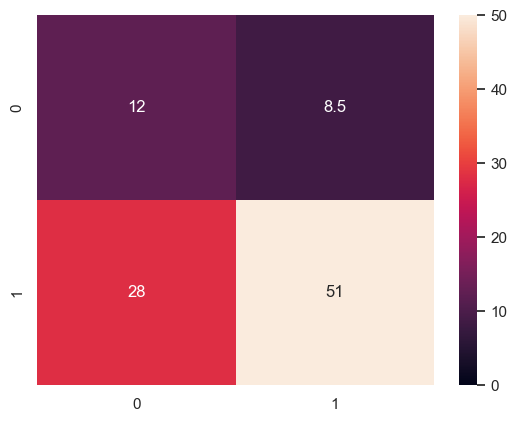

In [298]:

sb.heatmap(confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50)

# Permutation importances (a bit hard to interpret; many co-correlates)

0.028194444444444456

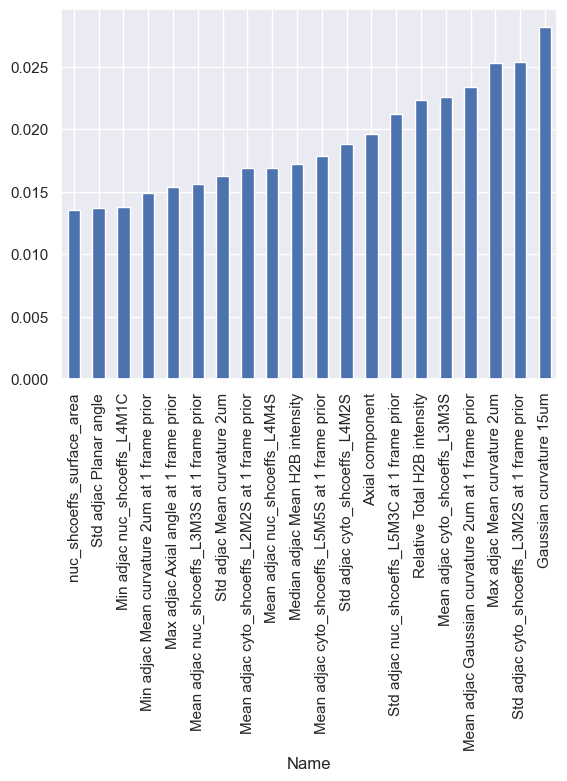

In [165]:
# Permutation importances
from sklearn.inspection import permutation_importance

df_ = get_balanced_df_by_category(divisions, divisions[feature2predict,'Meta'].values)

y = df_[feature2predict,'Meta'].astype(float)
X = df_.xs('Measurement',level=1,axis=1).astype(float)
X[np.isinf(X)] = np.nan
X['Region'] = df_['Region']
X = GroupedStandardScaler('Region').fit_transform(X)
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,random_state=55+1)

model = ensemble.RandomForestClassifier().fit(X_train,y_train)

r = permutation_importance(model, X_test, y_test,
                           n_repeats=1000,
                           random_state=90,
                          n_jobs=100)


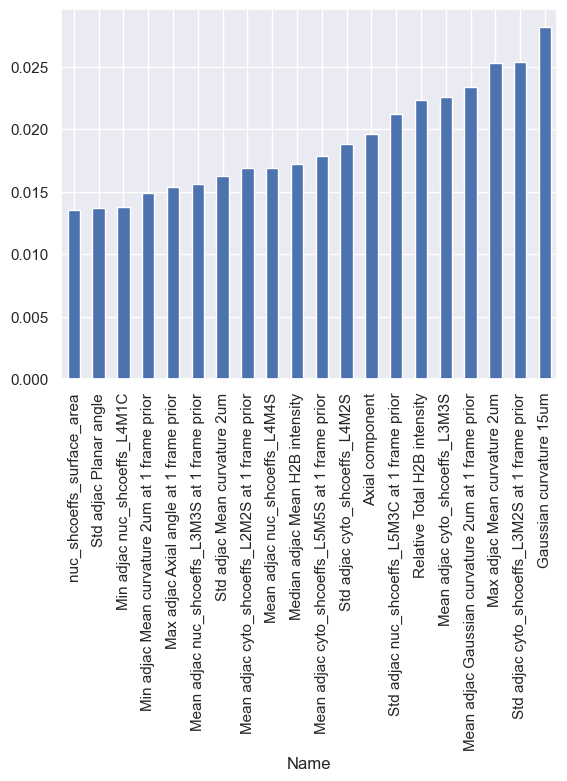

In [170]:

prm_imps = pd.Series(prm_imps,index=X_test.columns)
prm_imps.sort_values().tail(20).plot.bar()
prm_imps.max()

plt.savefig(path.join(model_dir,'RF_permutation_importances.svg'))

# Vary forest parameters

  0%|                                                                                            | 0/100 [00:00<?, ?it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
  3%|██▌                                                                                 | 3/100 [00:00<00:03, 28.76it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn

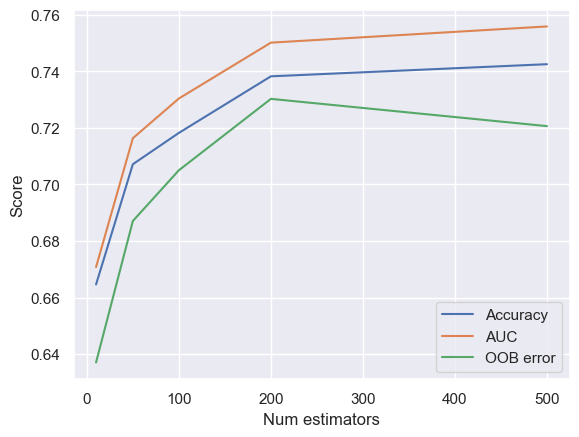

In [36]:
# Number of estimators
scores = pd.DataFrame(index=[10,50,100,200,500],columns=['Accuracy','AUC','OOB error'])
for num_trees in scores.index.values:
    predictions,models,training_sets = predict_feature(divisions,
                                     ensemble.RandomForestClassifier,feature2predict,
                                      model_params={'n_estimators':num_trees,'oob_score':True},
                                     Niter=100, subsample=55)
    # predictions,models,training_set = predict_feature(divisions,feature2predict,
    #                                      ensemble.RandomForestClassifier,
    #                                      model_params={'n_estimators':num_trees,'oob_score':True}
    #                                      ,Niter=100)
    scores.loc[num_trees,'Accuracy'] = np.array([metrics.accuracy_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[num_trees,'AUC'] = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[num_trees,'OOB error'] = np.array([m[1].oob_score_ for m in models]).mean()

plt.plot(scores)
plt.xlabel('Num estimators')
plt.ylabel('Score')
plt.legend(['Accuracy','AUC','OOB error'])

In [37]:
# Vary the depth with num_tree = 100
# Number of estimators
scores = pd.DataFrame(index=[0,2,3,4,9,10,15],columns=['Accuracy','AUC'])
for max_depth in scores.index.values:
    if max_depth == 0:
        max_depth_ = None
    else:
        max_depth_ = int(max_depth)
    predictions,models = predict_feature(divisions,
                                         ensemble.RandomForestClassifier(n_estimators = 100,max_depth=max_depth_),
                                         feature2predict,Niter=100)
    scores.loc[max_depth,'Accuracy'] = np.array([metrics.accuracy_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[max_depth,'AUC'] = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()

plt.plot(scores)
plt.xlabel('Max depth (0 = None)')
plt.ylabel('Score')
plt.legend()

  0%|                                                                                            | 0/100 [00:00<?, ?it/s]


TypeError: 'RandomForestClassifier' object is not callable

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.24it/s]
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_5927/2030959459.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


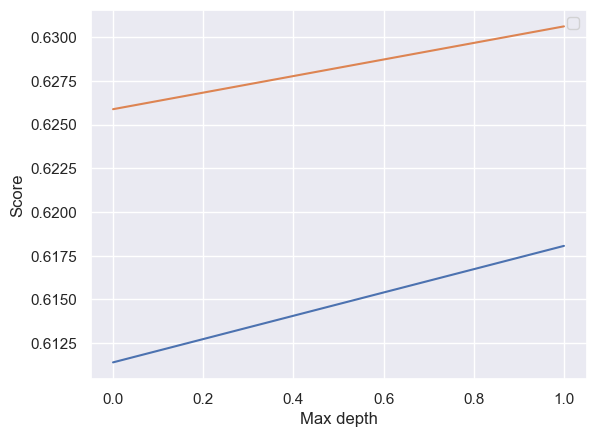

In [145]:
# Quantify out of bag error
# Vary the depth with num_tree = 100
# Number of estimators
scores = pd.DataFrame(index=[True,False],columns=['Accuracy','AUC'])
for oob in scores.index.values:
    predictions,models = predict_feature(divisions,
                                         ensemble.RandomForestClassifier(n_estimators = 100,oob_score=oob),
                                         feature2predict,Niter=100)
    scores.loc[oob,'Accuracy'] = np.array([metrics.accuracy_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()
    scores.loc[oob,'AUC'] = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])]).mean()

plt.plot(scores)
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.legend()

# Feature examination

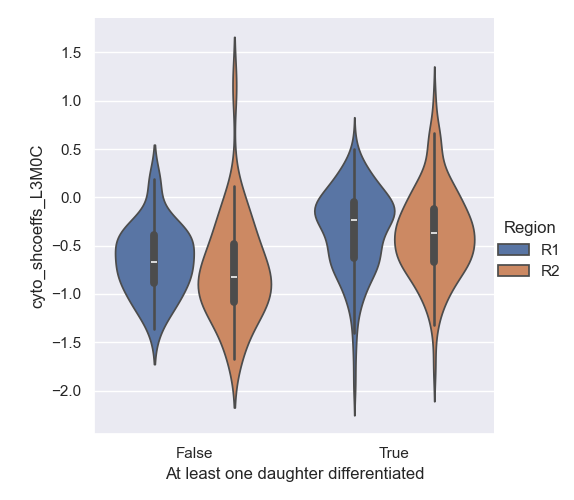

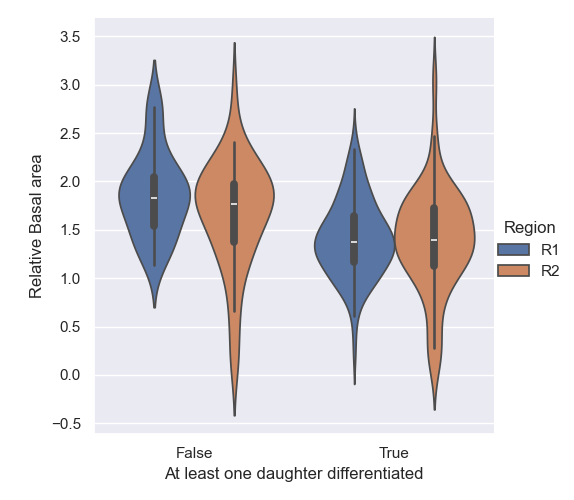

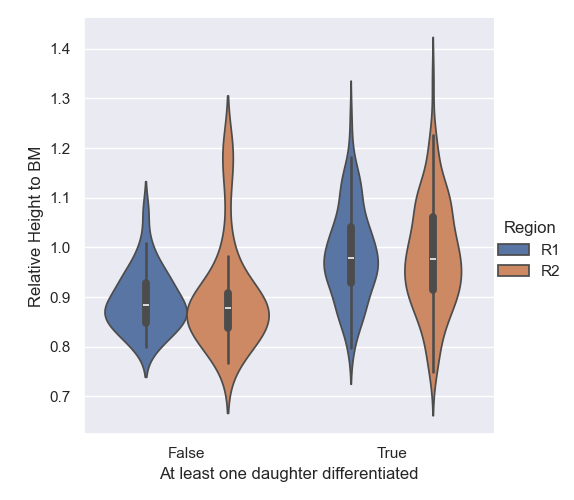

In [292]:
from basicUtils import ttest_from_groupby
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='cyto_shcoeffs_L3M0C',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Basal area',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Height to BM',kind='violin',hue='Region')


In [293]:
# from measurements import extract_nuc_and_cell_and_microenvironment_mask_from_idx
from imageUtils import trim_multimasks_to_shared_bounding_box, \
    pad_image_to_size_centered, create_average_object_from_multiple_masks
from measurements import extract_nuc_and_cell_and_microenvironment_mask_from_idx
import ipyvolume as ipv

standard_size = (30,150,150)

def get_display_of_average_nuc_cyto_micro(ncm_list,largest_size=None):
    nuc = [m[0] for m in ncm_list]
    cyto = [m[1] for m in ncm_list]
    micro = [m[2] for m in ncm_list]
    nuc = create_average_object_from_multiple_masks(nuc,prealign=False)
    cyto = create_average_object_from_multiple_masks(cyto,prealign=False)
    micro = create_average_object_from_multiple_masks(micro,prealign=False)

    if largest_size is None:
        largest_size = np.array((nuc.shape,cyto.shape,micro.shape)).max(axis=0)
    nuc = pad_image_to_size_centered(nuc,largest_size)
    cyto = pad_image_to_size_centered(cyto,largest_size)
    micro = pad_image_to_size_centered(micro,largest_size)
    return nuc,cyto,micro

# division_daughters_known = divisions[ ~np.isnan(divisions['At least one daughter differentiated','Meta']].xs('Measurement',level=1,axis=1)


In [307]:
print(division_fate_known.droplevel(1,axis=1).sort_values(by=value2sort).head(20)[value2sort])
print(division_fate_known.loc[1,'R2_1054']['Num daughter differentiated'])

Frame  TrackID
0      R1_2      -1.481487
2      R1_1028   -1.481191
10     R2_1063   -1.439933
2      R1_5      -1.211682
4      R1_1056   -1.161740
1      R2_1054   -1.142025
3      R2_1095   -1.130355
2      R2_142    -1.047924
       R2_1051   -1.045567
3      R1_1083   -1.025302
2      R2_1059   -0.922407
0      R2_5      -0.883513
       R2_67     -0.868190
6      R1_172    -0.823158
3      R2_229    -0.778103
5      R2_183    -0.775503
1      R2_1077   -0.752526
6      R2_340    -0.741950
1      R2_49     -0.734568
8      R2_184    -0.700075
Name: Mean curvature 10um, dtype: float64
Metadata
Meta    1.0
Name: (1, R2_1054), dtype: object


In [294]:
born_divide_masks = []

value2sort = 'Mean curvature 10um'

division_fate_known = \
    divisions[~np.isnan(divisions['At least one daughter differentiated','Meta'].astype(float))]
idx = division_fate_known.droplevel(axis=1,level=1).sort_values(by=value2sort).index[-2]
print(division_fate_known.loc[idx,value2sort])
print(idx)

born_divide_masks.append(extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region))

divide_nuc,divide_cyto,divide_micro = get_display_of_average_nuc_cyto_micro(born_divide_masks)
ipv.quickvolshow(10 * divide_nuc + 2*divide_cyto + divide_micro,
                 level=[.2,.5,1], opacity=0.05, level_width=0.05, data_min=0, data_max=2)

Metadata
Measurement    1.189826
Name: (5, R2_937), dtype: float64
(np.int64(5), 'R2_937')


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

<Axes: xlabel='nuc_shcoeffs_L3M2S', ylabel='Relative Height to BM'>

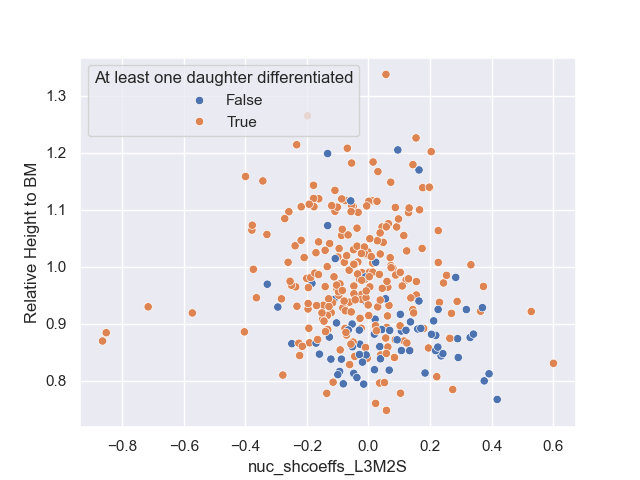

In [279]:
plt.figure()
sb.scatterplot(divisions.droplevel(axis=1,level=1),x='nuc_shcoeffs_L3M2S',
               hue='At least one daughter differentiated',
           y='Relative Height to BM')

Text(0.5, 0, 'Relative Nuclear volume')

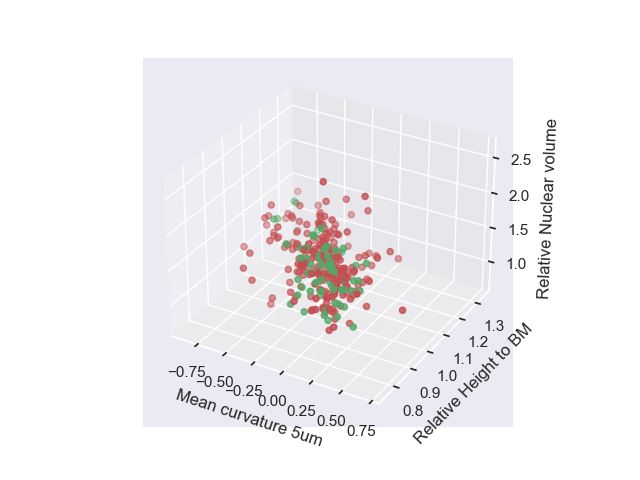

In [276]:
%matplotlib widget

x = 'Mean curvature 5um'
y = 'Relative Height to BM'
z = 'Relative Nuclear volume'

from mpl_toolkits.mplot3d import Axes3D
fate_colors = {True:'r',False:'g'}
marker_colors = [fate_colors[d['At least one daughter differentiated','Meta']] for _,d in division_fate_known.iterrows()]

ax = plt.figure().add_subplot(projection='3d')
sc = ax.scatter( xs = division_fate_known[x,'Measurement'].values,
            ys = division_fate_known[y,'Measurement'].values,
            zs = division_fate_known[z,'Measurement'].values,
           c = marker_colors,zdir='z')
plt.xlabel(x);plt.ylabel(y);ax.set_zlabel(z)


# Subset top 50 features

In [243]:
# Take top 50 features by importance and see their correlation matrix

top50feats = importances.mean().sort_values().dropna().tail(20).index
C50 = divisions.droplevel(axis=1,level=1)[top50feats].corr()

sb.set(font_scale=0.5)  # crazy big
sb.heatmap(C50)
C50.index.name = 'Feature1'
C50.columns.name = 'Feature2'
C50 = C50.stack().reset_index().sort_values(by=0)
C50 = C50[C50[0] < 1]
C50.tail(100)


ValueError: zero-size array to reduction operation fmin which has no identity

In [189]:
# linear model

from sklearn.linear_model import LogisticRegression

top50 = divisions.droplevel(axis=1,level=1).dropna(subset=feature2predict)[top50feats]
top50.columns = pd.MultiIndex.from_product([top50.columns,['Measurement']])
top50[(feature2predict,'Meta')] = divisions[feature2predict,'Meta']

top50 = top50.dropna()

predictions,models = predict_feature(top50, LogisticRegression, feature2predict,Niter=1000)


100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.67it/s]


0.6984910900637167


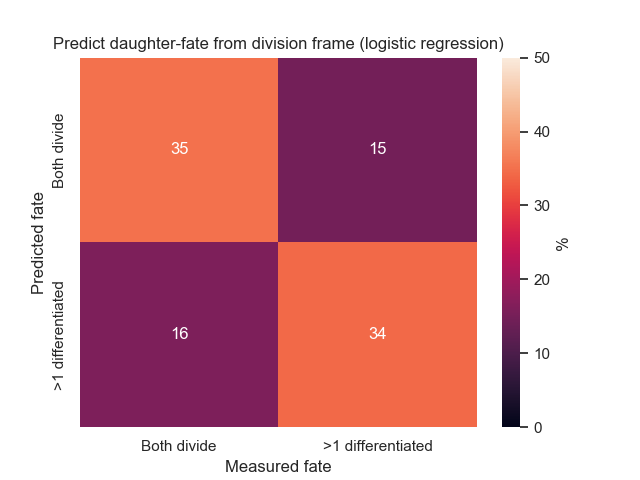

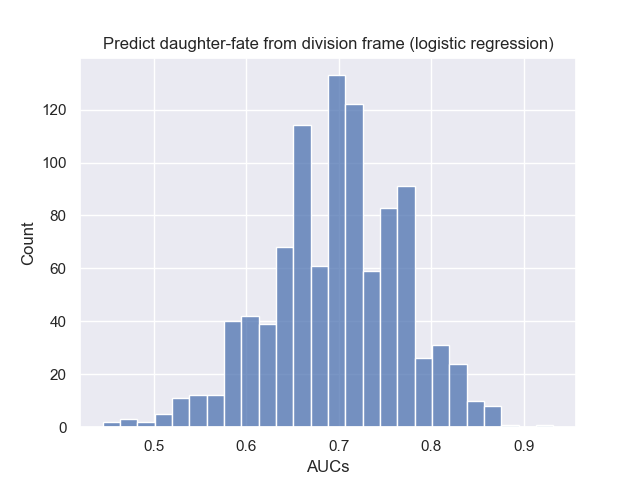

In [191]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

sb.set(font_scale=1)  # crazy big
plt.figure()
plt.title('Predict daughter-fate from division frame (logistic regression)')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.gca().set_xticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.gca().set_yticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (logistic regression)')
sb.histplot(AUCs)
plt.xlabel('AUCs')

print(AUCs.mean())

In [192]:
linear_importances['Mean curvature']

0      0.126191
1     -0.228934
2      0.219062
3     -0.441870
4     -0.518004
         ...   
995   -0.471127
996   -0.486430
997   -0.642598
998   -0.034116
999   -0.766187
Name: Mean curvature, Length: 1000, dtype: float64

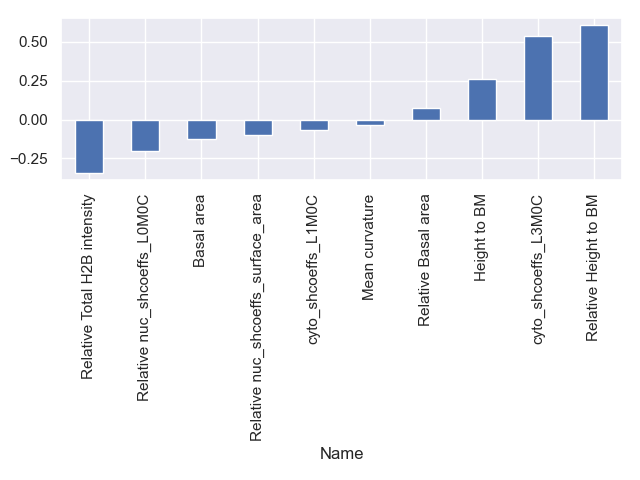

In [193]:
plt.figure()
linear_importances = pd.DataFrame( [np.squeeze(m[1].coef_) for m in models],columns=top50.xs('Measurement',level=1,axis=1).columns)

linear_importances.mean().sort_values().tail(20).plot.bar()
plt.tight_layout()

<Axes: xlabel='nuc_shcoeffs_L5M4S', ylabel='At least one daughter differentiated'>

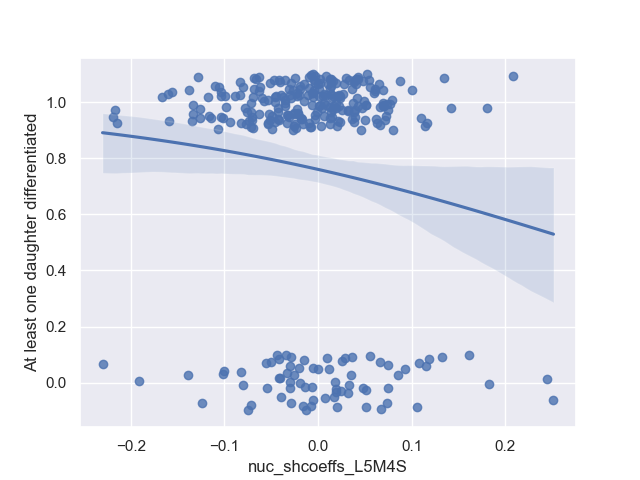

In [187]:
x = 'nuc_shcoeffs_L5M4S'
plt.figure()
sb.regplot(divisions.droplevel(axis=1,level=1)[[x,feature2predict]].astype(float),
           x=x,y=feature2predict,logistic=True, y_jitter=0.1)


## PCA, then linear prediction

In [137]:
#SubsetPCA and then regression

from ppca import PPCA

X = divisions.droplevel(axis=1,level=1).dropna(subset=feature2predict)[top50feats]
y = divisions.droplevel(axis=1,level=1).dropna(subset=feature2predict)[feature2predict]

ppca = PPCA()
ppca.fit(X.values,d=49)
components = pd.DataFrame(ppca.C, index=top50feats)
X_transform = ppca.transform()

100%|████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 114.14it/s]
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21374/17975097.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


0.674672903571317


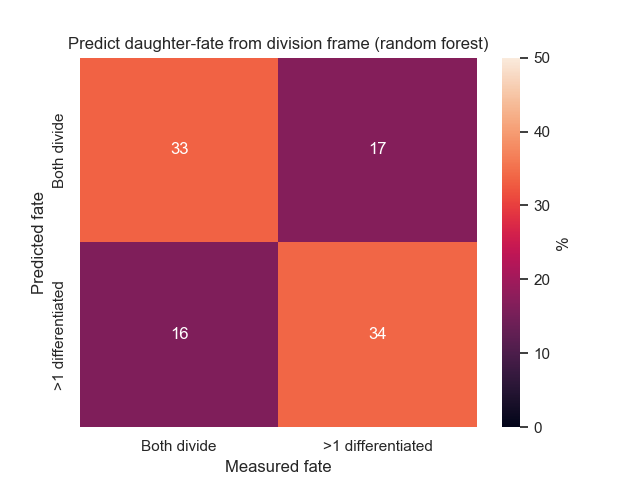

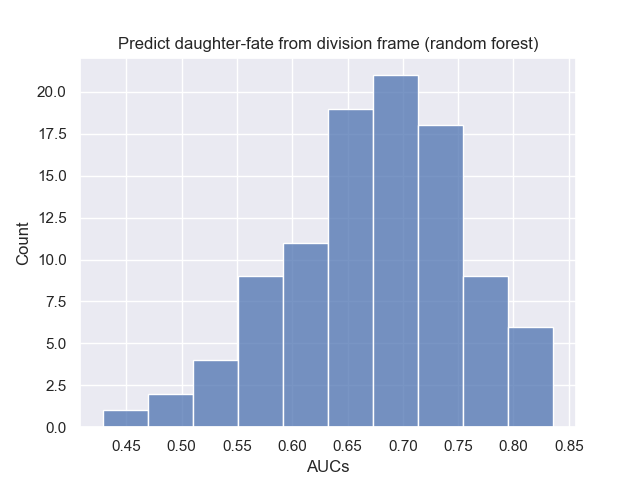

In [143]:
# linear model

from sklearn.linear_model import LogisticRegression

X_transformed = ppca.transform()
top50_ppca = pd.DataFrame(X_transformed,
                         columns=pd.MultiIndex.from_product([['PC'+str(i) for i in range(X_transformed.shape[1])],['Measurement']]) )
top50_ppca[feature2predict,'Meta'] = divisions[feature2predict,'Meta'].values

predictions,models = predict_feature(top50_ppca, LogisticRegression, feature2predict,Niter=100)

# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

sb.set(font_scale=1)  # crazy big
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0)*100,annot=True,vmin=0,vmax=50,
          cbar_kws={'label':'%'})
plt.gca().set_xticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.gca().set_yticks([0.5,1.5],labels=['Both divide','>1 differentiated'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')

print(AUCs.mean())

<Axes: >

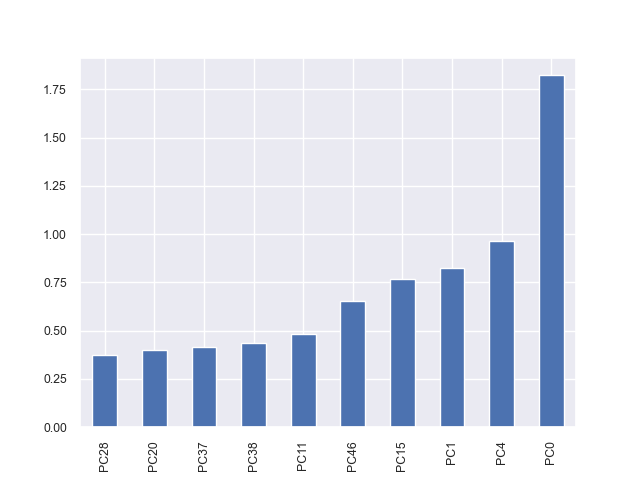

In [146]:
plt.figure()
pca_logit_coeffs = pd.Series(np.stack([np.squeeze(m[1].coef_) for m in models]).mean(axis=0),
                             ['PC'+str(i) for i in range(X_transformed.shape[1])] )
pca_logit_coeffs.abs().sort_values().tail(10).plot.bar()

<Axes: >

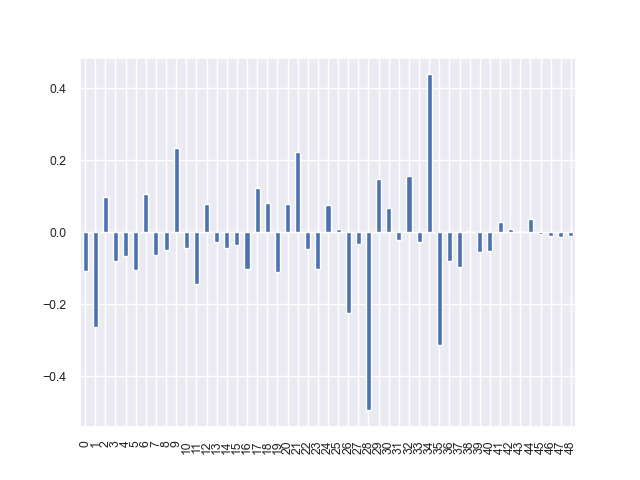

In [149]:
sb.set(font_scale=.8)  # crazy big
plt.figure()
components.loc['Mean curvature'].plot.bar()

In [150]:
components[0].sort_values()

Name
Relative Total H2B intensity                       -0.279127
Relative cyto_shcoeffs_surface_area                -0.265609
Relative Cell volume                               -0.253737
Relative cyto_shcoeffs_L0M0C                       -0.252884
Relative Basal area                                -0.219596
Relative nuc_shcoeffs_surface_area                 -0.216174
Relative Nuclear volume                            -0.211717
Relative Total FUCCI intensity                     -0.209312
Relative nuc_shcoeffs_L0M0C                        -0.198581
Relative Axial component                           -0.196440
Basal area                                         -0.172368
Mean adjac Nuclear height                          -0.137433
Axial component                                    -0.115130
cyto_shcoeffs_L1M0C                                -0.109758
Mean curvature                                     -0.108912
nuc_shcoeffs_L1M0C                                 -0.104304
Mean adjac Mean cur

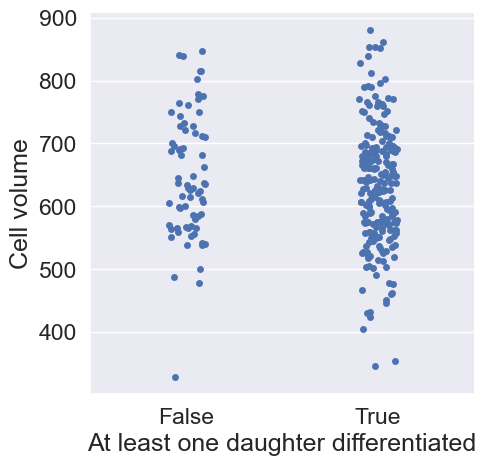

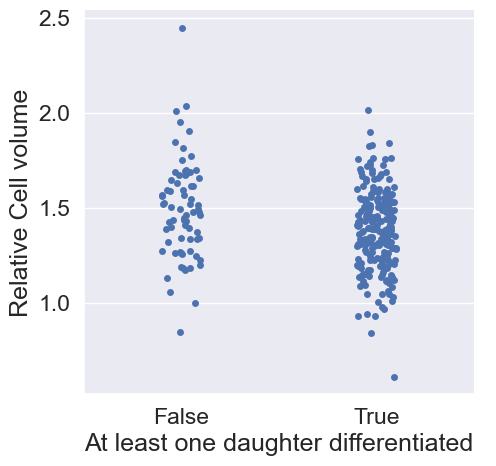

In [178]:
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Cell volume')
sb.catplot(divisions.droplevel(axis=1,level=1),x=feature2predict,y='Relative Cell volume')

### RFE

In [179]:
from sklearn import feature_selection

X = divisions.xs('Measurement',level=1,axis=1)
y = divisions[feature2predict,'Meta'].astype(bool)
m = ensemble.RandomForestClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

# optimal features: 2
Index(['cyto_shcoeffs_L3M0C', 'Relative Height to BM'], dtype='object', name='Name')


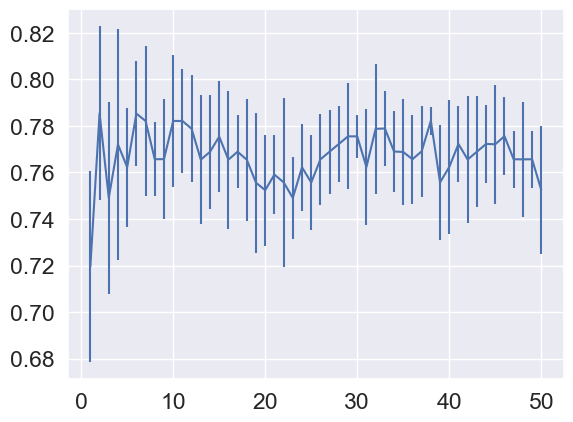

In [64]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])

print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)

## 2. ExtraTreesClassifier

In [65]:
# Run classifier
# axis0: observation axis1: prediction

predictions,models = predict_feature(divisions, ensemble.ExtraTreesClassifier, feature2predict,Niter=10000)


100%|█████████████████████████████████████████████████████████████| 10000/10000 [10:30<00:00, 15.86it/s]


Text(0.5, 0, 'AUCs')

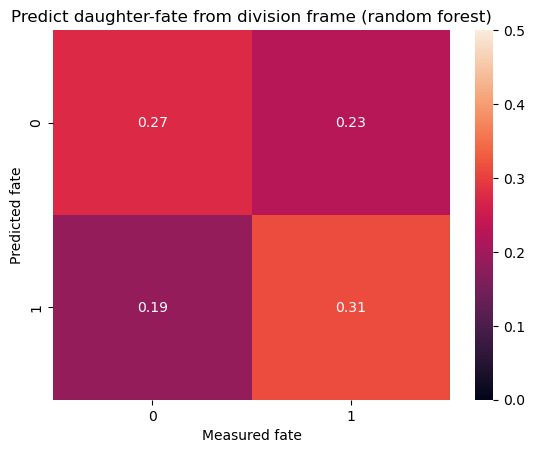

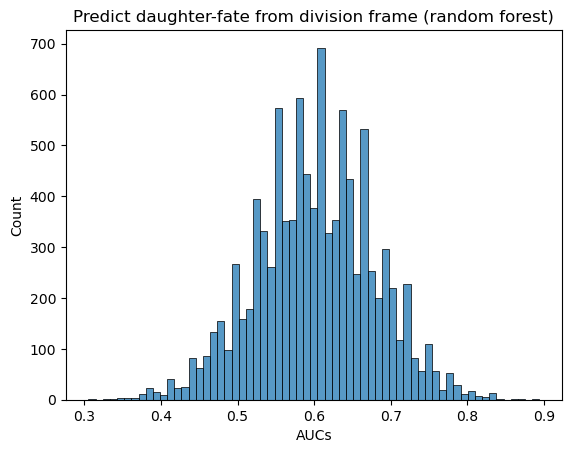

In [66]:
# Calculate the confusion matrix
avg_confusion = np.array([metrics.confusion_matrix(a,b)/len(a) for a,b in zip(predictions[0,:],predictions[1,:])])

plt.title('Predict daughter-fate from division frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
# plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
# plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

# Calculate AUC scores
AUCs = np.array([metrics.roc_auc_score(a,b) for a,b in zip(predictions[0,:],predictions[1,:])])
plt.figure()
plt.title('Predict daughter-fate from division frame (random forest)')
sb.histplot(AUCs)
plt.xlabel('AUCs')


Text(0, 0.5, 'Impurity importance')

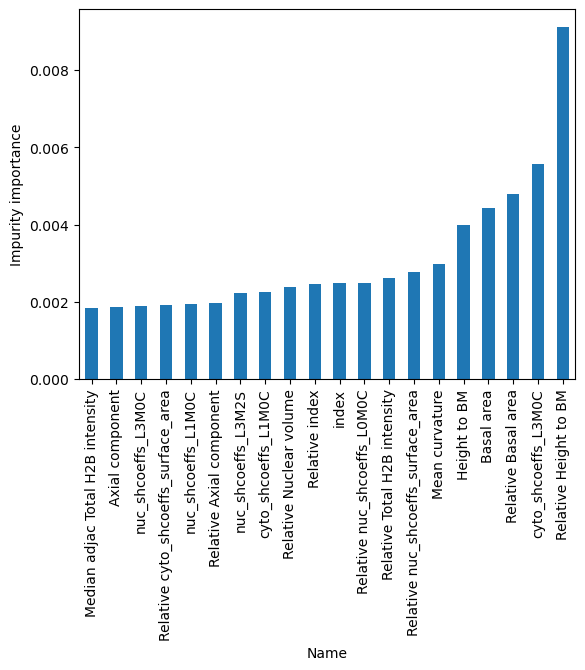

In [70]:
feat_names = divisions.xs('Measurement',level=1,axis=1).columns
importances = pd.DataFrame(columns = feat_names,index=range(len(models)))
for i,m in enumerate(models):
    importances.loc[i,:] = m[1].feature_importances_

importances.dropna(how='all').mean(axis=0).sort_values().dropna().tail(20).plot.bar()

plt.ylabel('Impurity importance')

In [97]:
from sklearn import feature_selection

X = divisions.xs('Measurement',level=1,axis=1)
y = divisions[feature2predict,'Meta'].astype(bool)
m = ensemble.ExtraTreesClassifier().fit(X,y)

results = feature_selection.RFECV(m).fit(X,y)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
plt.errorbar(x=results.cv_results_['n_features'][:50],
        y=results.cv_results_['mean_test_score'][:50],
        yerr=results.cv_results_['std_test_score'][:50])

print(f'# optimal features: {results.n_features_}')

selected = X.columns[ results.ranking_ == 1]
print(selected)


In [21]:
results.ranking_[X.columns == 'Mean curvature']

array([1])

# Misc: visualizations

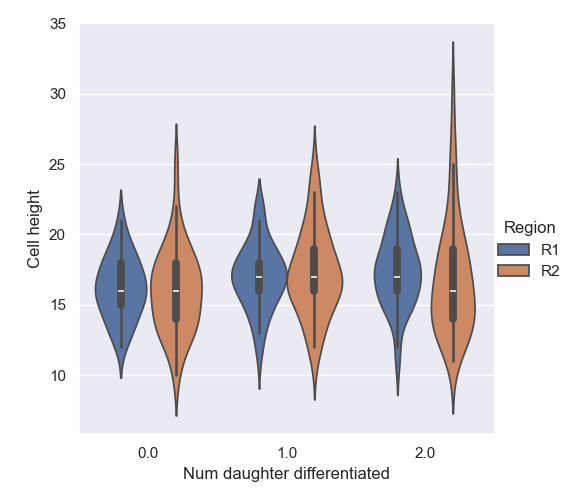

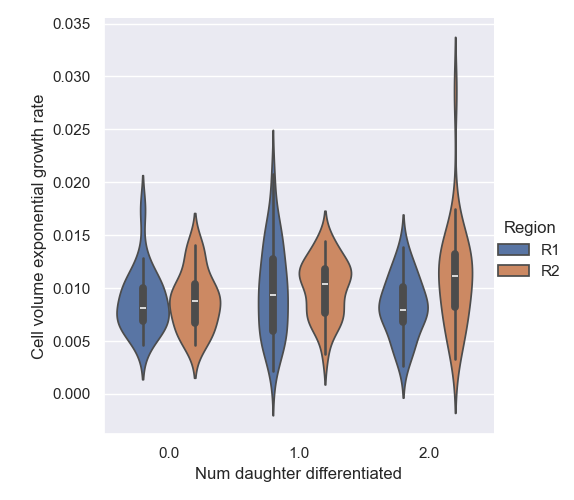

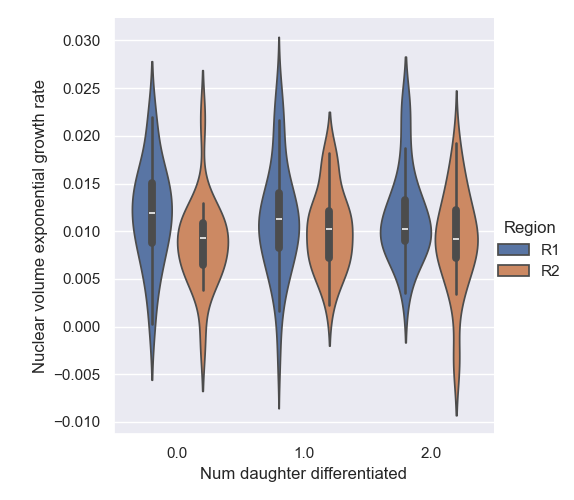

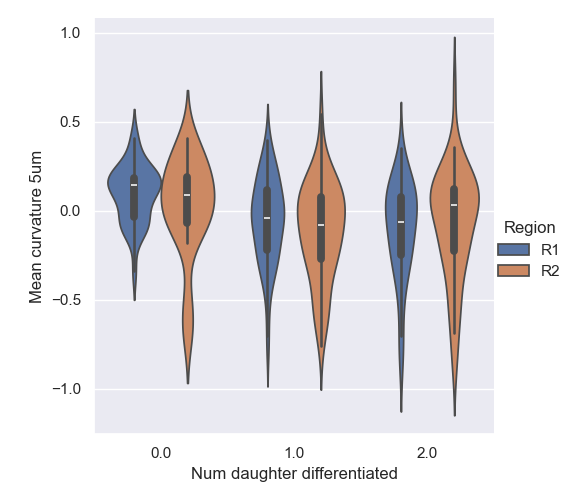

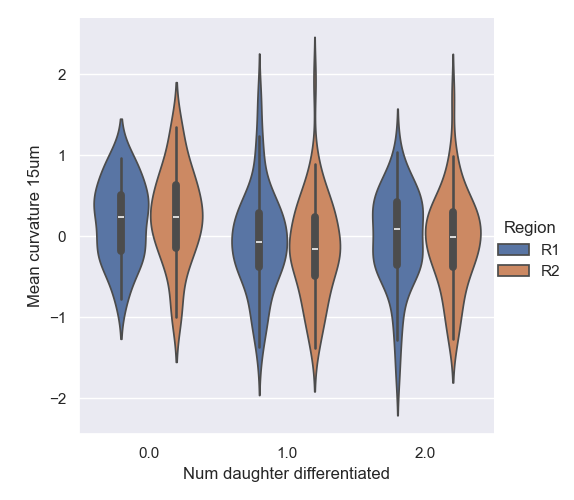

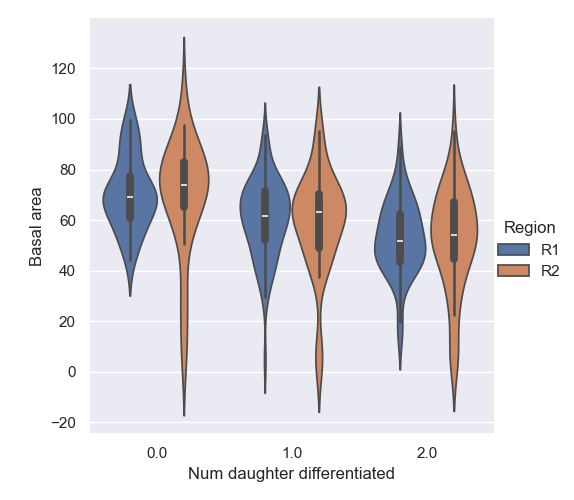

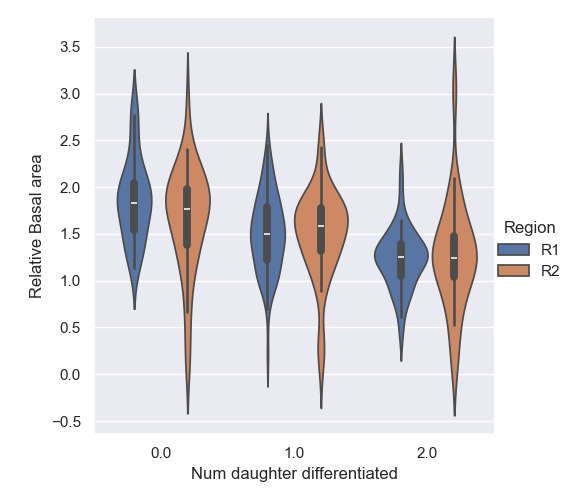

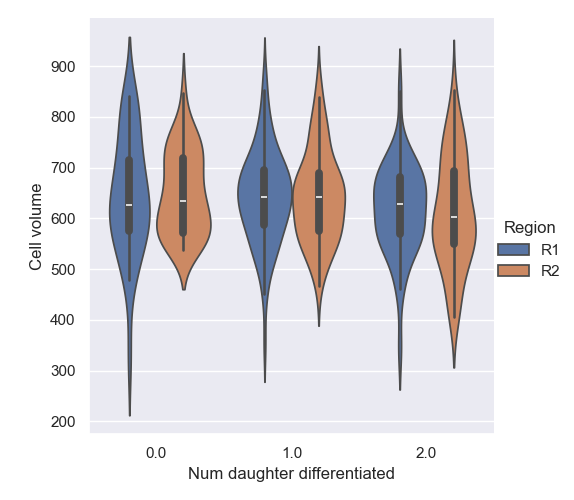

In [405]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Differentiation visualizations'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Cell height',
           kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',
           y='Cell volume exponential growth rate',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',
           y='Nuclear volume exponential growth rate',kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Mean curvature 5um',
           kind='violin',hue='Region')
plt.savefig(path.join(figure_dir,'mean_curv5_by_num_daughter_diff.svg'))
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Mean curvature 15um',
           kind='violin',hue='Region')
plt.savefig(path.join(figure_dir,'mean_curv10_by_num_daughter_diff.svg'))
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Basal area',
           kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Relative Basal area',
           kind='violin',hue='Region')
sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Cell volume',
           kind='violin',hue='Region')

In [174]:
features2drop = [f for f in all_df.droplevel(axis=1,level=1).columns if 'smoothed' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'shcoeffs' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'prior' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'standard' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'BM' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'intensity' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'Time' in f]
A = all_df.droplevel(axis=1,level=1).drop(
    columns=['X','X-pixels','Y','Y-pixels','X-cyto','Y-cyto','Z','Z-cyto',
             'Daughter a','Daughter b','Mother','Sister']+features2drop).select_dtypes(numerics).corr(numeric_only=True)

B = A.abs().unstack().sort_values(ascending=False)

unique_pairs = []
# Iterate over the top pairs and add only unique pairs to the list
for pair in B.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# Create a dataframe with the top pairs and their correlation coefficients
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    corr_df.loc[i] = [pair[0], pair[1], B.loc[pair[0], pair[1]]]

display(corr_df.dropna().head(50))


NameError: name 'numerics' is not defined

<Axes: xlabel='Subbasal collagen intensity', ylabel='Mean curvature 5um'>

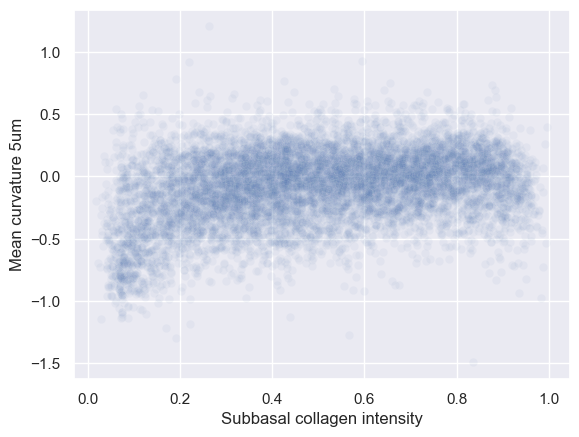

In [183]:
sb.scatterplot(all_df.droplevel(axis=1,level=1),x='Subbasal collagen intensity',y='Mean curvature 5um',alpha=0.05)